In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

from efficientnet_pytorch import EfficientNet

from PIL import Image
from skimage.transform import resize
from sklearn.metrics import confusion_matrix, roc_curve, auc
from scipy.stats import ks_2samp

from sklearn.utils.class_weight import compute_class_weight

from tqdm import tqdm

In [2]:
# Device configuration (GPU can be enabled in settings)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cuda:0


In [3]:
# upload train dataframe
path = "../../data-256/"
train_df_allsamples = pd.read_csv(path+"train.csv")
train_df_allsamples.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000


In [4]:
# upload test dataframe
test_df = pd.read_csv(path + 'test.csv')
test_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,width,height
0,ISIC_0052060,IP_3579794,male,70.0,NaN,6000,4000
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,6000,4000
2,ISIC_0058510,IP_7960270,female,55.0,torso,6000,4000
3,ISIC_0073313,IP_6375035,female,50.0,torso,6000,4000
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,1920,1080


In [5]:
# no flip or rotation for test/validation data 
transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

transform_noise = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=5),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=.2, contrast=.2, saturation=.2, hue=.2),
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.2), ratio=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, df, path_to_files, transform):
        # 1. Initialize file paths or a list of file names.
        self.path = path_to_files
        self.df = df
        self.transform = transform

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        
        # load X 
        img_name = self.df['image_name'].values[index]
        img_path = self.path + img_name + ".jpg"
        img = plt.imread(img_path) 
        
        # 2. Preprocess the data (e.g. torchvision.Transform)
        img_processed = self.transform(img)
        # 3. Return a data pair (e.g. image and label).
        return img_processed
        
    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]

In [6]:
# First, load the EfficientNet with pre-trained parameters 

class MyENet(nn.Module):
    def __init__(self, ENet):
        super(MyENet, self).__init__()
        # modify output layer of the pre-trained ENet 
        self.ENet = ENet
        num_ftrs = self.ENet._fc.in_features
        self.ENet._fc = nn.Linear(in_features=num_ftrs, out_features=1024)
        # map Enet output to melanoma decision 
        self.output = nn.Sequential(nn.LeakyReLU(),
                                    nn.Linear(1024, 1),
                                    nn.Sigmoid())
        
    def embedding(self, x):
        out = self.ENet(x)
        return out 
        
    def forward(self, x):
        out = self.ENet(x)
        out = self.output(out)
        return out

In [7]:
# path to test images 
test_path = path + "test/"

# define batch size and accumulation steps 
batchsize  = 12

# store predictions 
predictions = np.zeros(len(test_df))

# define n_folds
n_folds = 3
n_tta = 5

# loop through each fold model 
for i in np.arange(1, n_folds+1):
    print("fold {}".format(i))
    
    # load model 
    ENet = EfficientNet.from_pretrained('efficientnet-b0').to(device)
    model = MyENet(ENet).to(device)
    model.load_state_dict(torch.load('../Models/model_{}.ckpt'.format(i)))
    model.eval()
    
    # make predictions on test data
    infold_predictions = np.zeros(len(test_df))
    for j in range(n_tta):
        test_dataset = TestDataset(test_df, test_path, transform=transform_noise)                                              
        test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batchsize, shuffle=False)
        fold_pred = []
        for images in test_loader:
            # Forward pass
            images = images.to(device)
            fold_pred.append(model(images).detach().cpu().numpy())
        fold_pred = np.concatenate(fold_pred, axis=0).ravel()
        print(fold_pred[:5])
        infold_predictions += fold_pred / n_tta
    
    # store predictions
    predictions += infold_predictions / n_folds

fold 1
Loaded pretrained weights for efficientnet-b0
[1.2027913e-07 7.6503617e-05 1.1544043e-05 7.3587757e-06 1.2987974e-06]
[4.9596405e-08 2.1942940e-05 2.0028596e-08 1.3822418e-07 3.9053705e-04]
[4.7590902e-08 9.7890930e-05 3.4906295e-06 1.1110594e-05 6.7241735e-06]
[1.9897381e-05 3.8207061e-05 7.7875567e-10 1.5571079e-07 1.6320508e-04]
[7.2286181e-05 1.9868239e-06 3.0865202e-08 3.8673645e-07 2.3212566e-05]
fold 2
Loaded pretrained weights for efficientnet-b0
[1.03510490e-06 9.68814734e-03 5.38376844e-05 1.21857365e-05
 1.62494776e-03]
[1.7440309e-04 2.0093427e-03 8.0180037e-08 3.8829671e-06 2.4658402e-02]
[3.9318297e-04 7.1653659e-03 9.5118057e-06 1.9294350e-06 1.3415713e-04]
[5.1295211e-07 2.5852377e-04 2.3828173e-09 1.9970532e-04 7.9181325e-03]
[4.7239326e-05 2.5530292e-03 4.1679770e-05 1.1677391e-05 7.3013903e-04]
fold 3
Loaded pretrained weights for efficientnet-b0
[1.0363399e-03 1.5657827e-04 1.3483246e-06 1.1654355e-04 1.8618173e-04]
[1.3339240e-04 5.4070888e-06 7.7815258e-07 

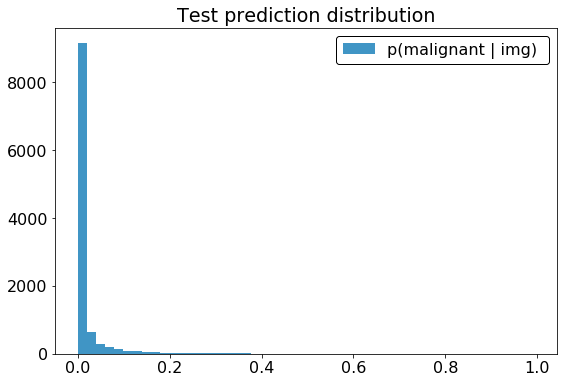

In [8]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

counts, bins = np.histogram(predictions, bins=50)
plt.hist(predictions, bins=bins, label='p(malignant | img) ', alpha=.75)

plt.legend()
plt.title("Test prediction distribution")
plt.show()

In [9]:
submission = pd.DataFrame()

image_names = test_df['image_name'].values
submission["image_name"] = image_names 
submission["target"] = predictions
submission.head()

,image_name,target
0,ISIC_0052060,0.000230
1,ISIC_0052349,0.001523
2,ISIC_0058510,0.000008
3,ISIC_0073313,0.000053
4,ISIC_0073502,0.006470


In [10]:
submission.to_csv("Submission.csv", index=False)